## **Build office-level auditor turnover panel data**
* Jie Xia, SUSTech
* 2025-02-20

# 1. Clean illegal characters in csv
* When importing the Revelio CSV into STATA, it was noticed that some rows were misinterpreted due to illegal characters in the file.

In [ ]:
import pandas as pd
import os
import numpy as np
import openpyxl

# 1. Read the CSV file
file_path = r"E:\USA auditor turnover data\merged_ouput_position.csv\merged_ouput_position.csv"
df = pd.read_csv(file_path)

# 2. Sort by user_id in ascending order
df_sorted = df.sort_values(by="user_id", ascending=True)

# 3. Define a function to remove illegal characters
def remove_illegal_chars(value):
    if isinstance(value, str):
        return "".join(char for char in value if char.isprintable())  # Keep only printable characters
    return value  # Leave non-string values unchanged

# 4. Apply the function to the entire DataFrame
df_sorted = df_sorted.applymap(remove_illegal_chars)

# 5. Ensure the output directory exists
output_dir = r"E:\USA auditor turnover data\turnover data"

df_sorted.to_csv(os.path.join(output_dir, "merged_ouput_position_cleaned.csv"), index=False)

print("Finished cleaning and saving csv files.")


# 2. Build Individual-year panel data
* Remove outliers and duplicates
* Expand the data across years
* Sort the DataFrame by user_id and year

## 2.1 Load in Revelio csv file

In [ ]:
import pandas as pd

source_data = r"E:\USA auditor turnover data\turnover data\merged_ouput_position_cleaned.csv"

df = pd.read_csv(source_data, engine="pyarrow") # use "pyarrow" can evidently accelerate the process
print("Successfully read csv file")

## 2.2 Show basic information of csv

In [ ]:
### Print basic info of csv
# df.head(10)
# df.describe()
# df.columns
# df.dtypes
print(f"The shape(rows, columns) of dataframe is {df.shape}")
print(f"{df.duplicated().sum()} rows are duplicated")

## 2.3 Cleaning dataset

* Clean missing and duplicate rows

In [ ]:
### Delete Missing and duplicated rows
# 1. Delete missing startdate rows
row1 = len(df)
df_cleaned = df.dropna(subset=['startdate'])
row2 = len(df_cleaned)

print(f"{row1 - row2} rows dropped because of missing startdate")
print(f"And {row2} rows left")

# 2. Delete duplicated rows
row3 = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates()
row4 = len(df_cleaned)

print(f"{row3 - row4} rows dropped because of duplicated")
print(f"And {row4} rows left")

# 3. Drop location and auditor missing rows
len1 = len(df_cleaned)
df_cleaned = df_cleaned.dropna(subset=['location_raw'])
len2 = len(df_cleaned)

len3 = len(df_cleaned)
df_cleaned = df_cleaned.dropna(subset=['AUDITOR_FKEY'])
len4 = len(df_cleaned)

len5 = len(df_cleaned)
df_cleaned = df_cleaned.dropna(subset=['AUDITOR_NAME'])
len6 = len(df_cleaned)

print(f"{len1 - len2} rows dropped because of missing location_raw")
print(f"And {len2} rows left")
print(f"{len3 - len4} rows dropped because of missing AUDITOR_FKEY")
print(f"And {len4} rows left")
print(f"{len5 - len6} rows dropped because of missing AUDITOR_NAME")
print(f"And {len6} rows left")

* Fill missing value in `enddate` column with 2024-12-31 to create 'present' date

In [ ]:
### Fill missing cell in enddate with 2024-12-31 (present)

print(f"{df_cleaned["enddate"].isna().sum()} rows of enddate columns are NaN.")

df_cleaned["enddate"] = df_cleaned["enddate"].fillna("2024-12-31")

print(f"{df_cleaned["enddate"].isna().sum()} rows of enddate columns are NaN after filling")

## 2.4 Extract year from date variables

In [ ]:
### Extract year variables
# 1. Ensure the date columns are datetime type
df_cleaned["startdate"] = pd.to_datetime(df_cleaned["startdate"])
df_cleaned["enddate"] = pd.to_datetime(df_cleaned["enddate"])

# 2. Check startdate and enddate
latest_start = df_cleaned["startdate"].max()  # Most recent (latest) start date
earliest_start = df_cleaned["startdate"].min()  # Oldest (earliest) start date

latest_end = df_cleaned["enddate"].max()  # Most recent (latest) end date
earliest_end = df_cleaned["enddate"].min()  # Oldest (earliest) end date

# Print results with clear labels
print(f"Latest (most recent) start date: {latest_start}")
print(f"Earliest (oldest) start date: {earliest_start}")

print(f"Latest (most recent) end date: {latest_end}")
print(f"Earliest (oldest) end date: {earliest_end}")

# 3. Extract year from date
df_cleaned["year_start"] = df_cleaned["startdate"].dt.year
df_cleaned["year_end"] = df_cleaned["enddate"].dt.year


## 2.5 Expand the years to create panel data
* Expand the year range from `year_start` to `year_end` into a consecutive series of years

In [ ]:
from tqdm import tqdm  # Import tqdm for progress bar
from pandasgui import show
### Build individual-year panel data
"""
# 1. Expand the rows by year (too slow)
expanded_rows = []
for _, row in df_cleaned.iterrows():
    for year in range(row["year_start"], row["year_end"] + 1):  # generate year ranges
        new_row = row.copy()  # copy entire rows
        new_row["year"] = year  # generate discrete year
        expanded_rows.append(new_row)
"""
# 1. Expand the rows by year
expanded_rows = []
columns = list(df_cleaned.columns) + ["year"]  # Preserve original columns and add "year"
print("Start to expand the rows")

# Iterate over rows using itertuples() (much faster than iterrows())
for row in tqdm(df_cleaned.itertuples(index=False), total=len(df_cleaned), desc="Expanding Rows"):
    for year in range(row.year_start, row.year_end + 1):  # Generate year range
        new_row = list(row) + [year]  # Copy entire row and add year column
        expanded_rows.append(new_row)
print("Successfully construct panel data")

# 2. Convert the expanded list into a DataFrame
df_panel = pd.DataFrame(expanded_rows, columns=columns)
print(f"The shape of dataframe is {df_panel.shape}")

# 3. Delete useless columns
df_panel = df_panel.drop(columns=["startdate", "enddate", "year_start", "year_end"])

# 4. Sort by id and year
df_panel = df_panel.sort_values(by=["user_id", "year"])



In [ ]:
# Save the DataFrame(about 32 mins)
individual_panel = r"E:\USA auditor turnover data\turnover data\individual_panel.csv"

print(f"Start to write output csv file")
df_panel.to_csv(individual_panel, index=False)

print(f"Successfully save individual_panel at {individual_panel}")

# 3. Calculate office-level variables
* AUDITOR_FLOW: Number of auditors who departed from(or join in) an audit office scaled by the number of auditors in an office-year
  
  * A flow-out auditor is defined as:
    * 1. Auditors who left the office
    * 2. Auditors who still work in same office but no longer work as an auditor
  
  * A flow-in auditor is defined as:
    * 1. New auditors who first join in the office
    * 2. Old employee who first start to work as an auditor in the office 
  
* HIGH_SALARY: if the salary offered by an audit office is greater than the sample median in an MSA
  
* MSA_OFFICES: Number of audit offices in an MSA in a year

## 3.1 Load the individual-year panel csv file
* Use chunking to load the file in parts
* Only include rows where the region is 'USA'

In [1]:
from pandasgui import show
import pandas as pd
from datetime import datetime

current_time = datetime.now()
input_csv = r"E:\USA auditor turnover data\turnover data\individual_panel.csv"

chunk_size = 100000  # Read 100,000 rows per chunk
filtered_chunks = []  # List to store filtered chunks

print(f"Begin to load in file at {current_time}")
# Read the CSV file in chunks to optimize memory usage (about 2 mins)
for chunk in pd.read_csv(input_csv, chunksize=chunk_size):
    chunk_filtered = chunk[chunk["country"] == "United States"]  # Filter rows where "country" is "United States"
    filtered_chunks.append(chunk_filtered)  # Store the filtered chunk

# Concatenate all filtered chunks into a single DataFrame
df_indivi_us = pd.concat(filtered_chunks, ignore_index=True)

row_indivi = len(df_indivi_us)  # Get the total number of rows after filtering
print("Successfully loaded file")
print(f"Shape of df: {df_indivi_us.shape}")  # Display the shape of the final DataFrame


Begin to load in file at 2025-02-20 00:12:37.853237


C:\Users\ASUS\AppData\Local\Temp\ipykernel_98484\18127546.py:13: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(input_csv, chunksize=chunk_size):
C:\Users\ASUS\AppData\Local\Temp\ipykernel_98484\18127546.py:13: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(input_csv, chunksize=chunk_size):


Successfully loaded file
Shape of df: (5090709, 59)


## 3.2 Filter individual panel using list from AA daa
* Filter individual panel using AA dta file based on AUDITOR_FKEY (have limited to USA office in STATA)
* Retain only the AUDITOR_FKEY values in the individual panel that have corresponding records in the AA dta file

In [2]:
# 1. Load in Audit Analytics data
current_time = datetime.now()
input_dta = r"E:\USA auditor turnover data\Audit Analytics data\AuditAnalytics_AUDITOR_USA.csv"

print(f"Begin to load in file at {current_time}")
df_aa = pd.read_csv(input_dta)

print("Successfully load in file")
print(f"Shape of df is {df_aa.shape}")

Begin to load in file at 2025-02-20 00:14:26.727351
Successfully load in file
Shape of df is (2114, 3)


In [3]:
# 2. Filter the AUDITOR by AA file
current_time = datetime.now()
df_filtered = df_indivi_us[df_indivi_us['AUDITOR_FKEY'].isin(df_aa['AUDITOR_FKEY'])]

# Calculate number of unmatched rows of df_indivi_us
unmatched_indivi = df_indivi_us[~df_indivi_us['AUDITOR_FKEY'].isin(df_aa['AUDITOR_FKEY'])].shape[0]

# Calculate number of unmatched rows of df_aa
unmatched_aa = df_aa[~df_aa['AUDITOR_FKEY'].isin(df_indivi_us['AUDITOR_FKEY'])].shape[0]

row_filtered = len(df_filtered)

print(f"Successfully matched at {current_time}\n"
      f"New df shape is {df_filtered.shape}\n"
      f"{row_indivi - row_filtered} rows dropped from df_indivi_us\n"
      f"{unmatched_indivi} rows in df_indivi_us were not matched\n"
      f"{unmatched_aa} rows in df_aa were not matched")


Successfully matched at 2025-02-20 00:14:26.736581
New df shape is (4430418, 59)
660291 rows dropped from df_indivi_us
660291 rows in df_indivi_us were not matched
687 rows in df_aa were not matched


In [4]:
# Delete dataframe, release memory
del df_indivi_us

## 3.3 Clean Revelio dataset

### 3.3.1 Standardize office location expression (city-level)
* When manually checking the `location_raw` column in revelio labs data, it was observed that the same city may by expressed in different ways. Therefore, standardizing these expressions is necessary to later build a consistent `office_key_location` and `office_id` latter.
  
1. Extract City Name:

   * Extract the substring before a comma from location_raw and convert it to title case.

2. Clean the Text:

   * Trim whitespace, remove parentheses (and their content), strip punctuation, eliminate extra spaces, remove unwanted words, replace abbreviations, and correct typos—all while ensuring proper capitalization.

3. Standardize City Names:

   * Replace any variants of known city names (from a predefined list) with a standardized version.

4. Drop Outliers:

   * Remove rows with invalid city entries (e.g., 'Uk', 'Usa', etc.) and those with an empty state.

5. Special Handling for Washington, D.C.:

   * Standardize variants of "Washington, D.C." to "Washington DC" and update the state to "District Of Columbia."

6. Manual Corrections:

   * Manually fix specific cases where cleaning did not remove unwanted suffixes or stray characters.
  
* Some examples of standardized city expression:
  * New York:
    * New York City And San Diego
    * New York City Area
    * New York City Office
    * New York Ny
    * New York City Metropolitan Area
    * New-York + Los Angeles
    * New York Metro Area (Short Hills)
    * New York City -4 Yrs & Atlanta
  * 300 Madison Avenue:
    * 300 Madison Avenue New York
    * 300 Madison Ave
    * 300 Madison Ave.
    * 300 Madison Ave
  * Los Angeles:
    * Los Angeles & San Jose
    * Los Angeles Ca
    * Los Angeles County
    * Los Angeles Metropolitan Area
    * Los Angeles/San Francisco   

In [5]:
import re
import pandas as pd

# Create "office_key_location" column (combination of AUDITOR_FKEY + office_location)
def extract_city_location(x):
    """
    Extracts the city part from a raw location string.
    If a comma is present, extract the substring before the first comma,
    trim whitespace, and convert to title case. Otherwise, just trim and title-case.
    """
    if isinstance(x, str) and ',' in x:
        return x.split(',')[0].strip().title()
    else:
        return x.strip().title()
    
def clean_text(text):
    """
    Cleans and normalizes the text string by performing several steps:
    1. Remove extra whitespace and unwanted punctuation:
       - Trim whitespace.
       - Remove content within parentheses.
       - Replace punctuation with spaces.
       - Remove extra spaces.
       - Remove specific unwanted words (e.g., 'pwc', 'remote', 'township of', 'U S A', 'Greater').
    2. Replace abbreviations with full names:
       - 'ave' becomes 'avenue'
       - 'ny' or 'nyc' becomes 'New York'
       - 'ca' becomes 'California'
       - 'Nj' becomes 'New Jersey'
       - 'Wv' becomes 'West Virginia'
    3. Correct typos and handle specific cases:
       - Replace common misspellings and variants (e.g., 'Wahsington' -> 'Washington',
         'Appletonoshkoshneenah' -> 'Appleton', 'Chcago' -> 'Chicago', etc.).
       - Handle cases like "Baltimore And Los Angeles" by converting them to "Los Angeles".
    4. Standardize names to match Audit Analytics data:
       - Convert variants like 'Champaign County' to 'Champaign', 'Metro Park' to 'Metropark',
         'Monmouth' to 'Monmouth Beach', etc.
    5. Remove extra suffixes:
       - Remove unwanted suffixes (listed in remove_suffixes) from the end of the string,
         provided the suffix is not the entire string.
    6. Final formatting:
       - Remove any remaining extra spaces, trim the string, and convert to title case.
    """
    if pd.isna(text):  # Handle NaN values
        return text
    
    # Step 1: Remove punctuation and unwanted words
    text = text.strip()
    text = re.sub(r'\(.*?\)', '', text)  # Remove parentheses and their content
    text = re.sub(r'[^\w\s]', ' ', text)  # Replace punctuation with space
    text = re.sub(r'\s+', ' ', text.strip())  # Remove extra spaces
    text = re.sub(r'\bpwc\b', '', text.strip(), flags=re.IGNORECASE)
    text = re.sub(r'\bremote\b', '', text.strip(), flags=re.IGNORECASE)
    text = re.sub(r"\btownship of\b", '', text.strip(), flags=re.IGNORECASE)
    text = re.sub(r"\bU S A\b", '', text.strip(), flags=re.IGNORECASE)
    text = re.sub(r"\bGreater\b", '', text.strip(), flags=re.IGNORECASE)
    text = text.strip()

    # Step 2: Replace abbreviations
    text = re.sub(r'\bave\b', 'avenue', text, flags=re.IGNORECASE)
    text = re.sub(r'\bny\b', 'New York', text, flags=re.IGNORECASE)
    text = re.sub(r'\bca\b', 'California', text, flags=re.IGNORECASE)
    text = re.sub(r'\bNj\b', 'New Jersey', text, flags=re.IGNORECASE)
    text = re.sub(r'\bnyc\b', 'New York', text, flags=re.IGNORECASE)
    text = re.sub(r'\bWv\b', 'West Virginia', text, flags=re.IGNORECASE)

    # Step 3: Correct typos and handle specific cases
    text = re.sub(r'\bWahsington\b', 'Washington', text, flags=re.IGNORECASE)
    text = re.sub(r'\bAppletonoshkoshneenah\b', 'Appleton', text, flags=re.IGNORECASE)
    text = re.sub(r'\bBaltimore And Los Angeles\b', 'Los Angeles', text, flags=re.IGNORECASE)
    text = re.sub(r'\bBethseda\b', 'Bethesda', text, flags=re.IGNORECASE)
    text = re.sub(r'\bBogot\b', 'Bogota', text, flags=re.IGNORECASE)
    text = re.sub(r'\bChcago\b', 'Chicago', text, flags=re.IGNORECASE)
    text = re.sub(r'\bClark Summit\b', 'Clarks Summit', text, flags=re.IGNORECASE)
    text = re.sub(r'\bDalls\b', 'Dallas', text, flags=re.IGNORECASE)
    text = re.sub(r'\bFlorhampark\b', 'Florham Park', text, flags=re.IGNORECASE)
    text = re.sub(r'\bIndinapolis\b', 'Indianapolis', text, flags=re.IGNORECASE)
    text = re.sub(r'\bLee S Summit\b', 'Lees Summit', text, flags=re.IGNORECASE)
    text = re.sub(r'\bLos Angele\b', 'Los Angeles', text, flags=re.IGNORECASE)
    text = re.sub(r'\bMetropark\b', 'Metro Park', text, flags=re.IGNORECASE)
    text = re.sub(r'\bMilwakukee\b', 'Milwaukee', text, flags=re.IGNORECASE)
    text = re.sub(r'\bMilwuakee\b', 'Milwaukee', text, flags=re.IGNORECASE)
    text = re.sub(r'\bPhiladephia\b', 'Philadelphia', text, flags=re.IGNORECASE)
    text = re.sub(r'\bPhoenx Az\b', 'Phoenix', text, flags=re.IGNORECASE)
    text = re.sub(r'\bRanch Cucamonga\b', 'Rancho Cucamonga', text, flags=re.IGNORECASE)
    text = re.sub(r'\bRancho Cucamona\b', 'Rancho Cucamonga', text, flags=re.IGNORECASE)
    text = re.sub(r'\bRgion De Binghamton\b', 'Binghamton', text, flags=re.IGNORECASE)
    text = re.sub(r'\bRgion De La Baie De San Francisco\b', 'San Francisco', text, flags=re.IGNORECASE)
    text = re.sub(r'\bRgion De New York\b', 'New York', text, flags=re.IGNORECASE)
    text = re.sub(r'\bRgion De Washington D C Metro\b', 'Washington D C', text, flags=re.IGNORECASE)
    text = re.sub(r'\bPhila\b', 'Philadelphia', text, flags=re.IGNORECASE)
    text = re.sub(r'\bTyson\b', 'Tysons', text, flags=re.IGNORECASE)
    text = re.sub(r'\bAubun Hills\b', 'Auburn Hills', text, flags=re.IGNORECASE)
    text = re.sub(r'\bTyson\b', 'Tysons', text, flags=re.IGNORECASE)
    text = re.sub(r'\bMaryland And Pennsylvania Offices\b', 'Maryland', text, flags=re.IGNORECASE)
    text = re.sub(r'\bSan Jos\b', 'San Jose', text, flags=re.IGNORECASE)
    text = re.sub(r'\bLouisvlle\b', 'Louisville', text, flags=re.IGNORECASE)
    text = re.sub(r'\bMiasmi\b', 'Miami', text, flags=re.IGNORECASE)
    text = re.sub(r'\bNew Olreans\b', 'New Orleans', text, flags=re.IGNORECASE)
    text = re.sub(r'\bPhladelphia\b', 'Philadelphia', text, flags=re.IGNORECASE)
    text = re.sub(r'\bWilkes Bare\b', 'Wilkes Barre', text, flags=re.IGNORECASE)
   
    # Step 4: Standardize to Audit Analytics city names
    text = re.sub(r'\bChampaign County\b', 'Champaign', text, flags=re.IGNORECASE)
    text = re.sub(r'\bMetro Park\b', 'Metropark', text, flags=re.IGNORECASE)
    text = re.sub(r'\bMonmouth\b', 'Monmouth Beach', text, flags=re.IGNORECASE)
    text = re.sub(r'\bOklahoma\b$', 'Oklahoma City', text, flags=re.IGNORECASE)
    text = re.sub(r'\bSalt Lake County\b$', 'Salt Lake CITY', text, flags=re.IGNORECASE)
    text = re.sub(r'\bShort Hill\b', 'Short Hills', text, flags=re.IGNORECASE)
    text = re.sub(r'\bTyson s\b', 'Tysons', text, flags=re.IGNORECASE)
    text = re.sub(r'\bWoodland\b', 'Woodland Hills', text, flags=re.IGNORECASE)
    text = re.sub(r'\bKansas\b$', 'Kansas City', text, flags=re.IGNORECASE)
    text = re.sub(r'\b3 Embarcadero Center San Francisco\b', 'San Francisco', text, flags=re.IGNORECASE)
    text = re.sub(r'\b465 California St San Francisco\b', 'San Francisco', text, flags=re.IGNORECASE)

    # Step 5: Remove extra suffixes
    remove_suffixes = [
        "new york", "junction", "maine", "md", "irvine", "normal", "indianapolis",
        "fl", "d c", "denver", "metropolitan area", "area", "north carolina", "oh", "wv",
        "ohio", "nj", "region", "sc", "indiana", "nv", 'usa', "ne", "arkansas", "ky",
        "va", "new jersey", "florida", "metropolitan", "wi", "minnesota", "office newark",
        "ct", "az", "pa", "mi", "ri", "mn", "wa", "ut", "Il", "Ii", "ll", "li", "ma", "virginia"
    ]

    # Remove each suffix from the end if it's not the entire string
    for suffix in remove_suffixes:
        if text.lower() != suffix:
            text = re.sub(fr'\b{re.escape(suffix)}\b$', '', text, flags=re.IGNORECASE)

    # Step 6: Final formatting
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.strip()
    text = text.title()  # Convert to title case
    return text

def standardize_location(df):
    """
    Standardizes the office city names using a predefined list of city names.
    For each city in the list, if the cleaned city name starts with that city,
    replace the entire string with the standardized city name.
    """
    cities = [
        "Atlanta", "Antwerp", "Appleton", "New York", "Newport Beach", "Baltimore", "Baton Rouge",
        "Bogota", "Boise", "Boston", "Buffalo Niagara", "Cape Coral", "Century", "Chicago",
        "Cincinnati", "College Station", "Columbus", "Conroe", "Dallas", "Denver", "Des Moines",
        "Destin", "Detroit", "Downtown", "Dublin", "Eau Claire", "El Paso", "Fargo", "Ft Lauderdale",
        "Gainesville", "Galway", "Ghent", "Gothenburg", "Grand Rapids", "Greater Boston",
        "Greater Chicago", "Greater Los Angeles", "Greater Minneapolis", "Greater New York",
        "Greater Philadelphia", "Greater San Diego", "Greater Washington", "Hartford", "Haverford",
        "Irvine", "Janesville", "Kansas City", "Knoxville", "La Jolla", "Las Vegas", "Leeds",
        "Limerick", "Little Rock", "London", "Los Angeles", "Louisville", "Memphis",
        "Miami Fort Lauderdale", "Mobile", "Nashville", "National", "Norfolk", "Nueva York",
        "Oakland", "Omaha", "Orlando", "Pensacola", "Philadelphia", "Phoenix", "Radnor",
        "Raleigh Durham Chapel Hill", "Richmond", "Sacramento", "San Diego", "San Francisco Bay",
        "San Ramon", "Shreveport", "South Bend", "Springfield", "St Louis", "Stamford",
        "State College", "Syracuse", "Tallahassee", "Tampa", "Texas", "Troy", "Tulsa", "Tysons",
        "Urbana", "Wausau", "Avon", "Bowling Green", "Byron", "California", "Charlotte",
        "Clarksburg", "Dayton", "Englewood", "Fort Lauderdale", "Greater Detroit",
        "Greater Milwaukee", "Greater New Orleans", "Greater Pittsburgh", "Greater St Louis",
        "Greensboro Winston Salem High Point", "Greenville", "Houston", "Iowa City Cedar Rapids",
        "Killeen Temple", "Lexington", "Lincoln", "Macomb", "Milwaukee", "New London", "San Jose",
        "Skokie", "Buffalo", "Cleveland", "Fort Worth", "Greensboro", "Hickory", "Huntington",
        "Lancaster", "Mclean", "Miami", "Midland", "Minneapolis", "New Haven", "Orange County",
        "Peoria", "Portland", "Providence", "Raleigh", "Rochester", "Santa Clara", "Spartanburg",
        "Spokane", "New Orleans", "Oklahoma City", "Salt Lake City"
    ]

    # Replace any string starting with a city name with the standardized name
    for city in cities:
        df['office_city_cleaned'] = df['office_city_cleaned'].str.replace(
            fr'^{re.escape(city)}\b.*', city, case=False, regex=True
        )

    df['office_city_cleaned'] = df['office_city_cleaned'].str.title().str.strip()
    return df

def drop_outlier(df):
    """
    Removes rows with invalid city names or empty states.
    Specifically, drop rows where office_city_cleaned is one of ['Uk', 'Usa', 'Us', '757']
    or where the state is marked as 'empty'.
    """
    df = df[~df['office_city_cleaned'].isin(['Uk', 'Usa', 'Us', '757'])]
    df = df[df['state'] != 'empty']
    return df

# Extract initial office city from raw location
df_filtered['office_city_raw'] = df_filtered['location_raw'].apply(extract_city_location)

# Clean the raw office city text
df_filtered['office_city_cleaned'] = df_filtered['office_city_raw'].apply(clean_text)

# Standardize office city names using a predefined list
df_filtered = standardize_location(df_filtered)

# Drop outlier rows with invalid city names or empty states
df_filtered = drop_outlier(df_filtered)

### Special handling for Washington, D.C.
# Step 1: For rows where state is "Washington, D.C." and the cleaned city contains "Washington",
# set the office city to "Washington DC".
mask1 = (
    (df_filtered['state'] == "Washington, D.C.")
    & (df_filtered['office_city_cleaned'].str.contains(r'\bWashington\b', case=False, na=False))
)
df_filtered.loc[mask1, 'office_city_cleaned'] = "Washington DC"

# Step 2: Normalize variants of "Washington DC" using regex (ignoring case)
mask2 = df_filtered['office_city_cleaned'].str.contains(r'(?i)\bwashington\s*d\s*c\b', na=False)
df_filtered.loc[mask2, 'office_city_cleaned'] = 'Washington DC'

# Step 3: For rows with "Washington DC", update the state to "District Of Columbia"
mask3 = df_filtered['office_city_cleaned'].str.strip() == "Washington DC"
df_filtered.loc[mask3, 'state'] = 'District Of Columbia'

### Manual corrections for specific cases
# Fix isolated "New" to "New York" (accounting for possible invisible characters)
df_filtered['office_city_cleaned'] = df_filtered['office_city_cleaned'].str.strip()
df_filtered['office_city_cleaned'] = df_filtered['office_city_cleaned'].str.replace(
    r'^\s*New\s*$', 'New York', flags=re.IGNORECASE, regex=True
)

# Fix "Peoria Metropolitan Area" to "Peoria"
df_filtered['office_city_cleaned'] = df_filtered['office_city_cleaned'].str.strip()
df_filtered['office_city_cleaned'] = df_filtered['office_city_cleaned'].str.replace(
    r'^\s*Peoria Metropolitan Area\s*$', 'Peoria', flags=re.IGNORECASE, regex=True
)

# Fix "Greensboro Winston Salem" variants to "Greensboro"
df_filtered['office_city_cleaned'] = df_filtered['office_city_cleaned'].str.strip()
df_filtered['office_city_cleaned'] = df_filtered['office_city_cleaned'].str.replace(
    r'^\s*Greensboro Winston Salem\s*$', 'Greensboro', flags=re.IGNORECASE, regex=True
)
df_filtered['office_city_cleaned'] = df_filtered['office_city_cleaned'].str.replace(
    r'^\s*Greensboro Winston Salem High Point\s*$', 'Greensboro', flags=re.IGNORECASE, regex=True
)

# Fix "Hickory Lenoir" to "Hickory"
df_filtered['office_city_cleaned'] = df_filtered['office_city_cleaned'].str.strip()
df_filtered['office_city_cleaned'] = df_filtered['office_city_cleaned'].str.replace(
    r'^\s*Hickory Lenoir\s*$', 'Hickory', flags=re.IGNORECASE, regex=True
)

print(f"There are {df_filtered['office_city_cleaned'].nunique()} unique cities after cleaning")


There are 9611 unique cities after cleaning


### 3.3.2 Create office_id and mas_id
* Standardize the `location_raw` (when manually check, find out that same location have different experssions)
  * If the `location_raw` string has ",", only extract the string before first ","
    * Those without ",", get the entire string
  * Then merge extracted string from `location_raw` with `state` to create `office_location`
* Next, merge `AUDITOR_FKEY` with `office_location` to create office-level identification `office_key_location`
* Use `office_key_location` to create `office_id`

In [6]:

# 1. Generate office_id
# Ensure the "AUDITOR_FKEY" and "AUDITOR_NAME" columns are strings
df_filtered["AUDITOR_FKEY"] = df_filtered["AUDITOR_FKEY"].astype(str)
df_filtered["AUDITOR_NAME"] = df_filtered["AUDITOR_NAME"].astype(str)


df_filtered['office_location'] = df_filtered['office_city_cleaned'].str.strip() + ',' + ' ' + df_filtered['state'].str.strip()
df_filtered['office_key_location'] = df_filtered['AUDITOR_FKEY'] + ',' + ' ' + df_filtered['office_location'] 

# Create "office_fullname" column (AUDITOR_NAME + loffice_location)
df_filtered["office_fullname"] = df_filtered["AUDITOR_NAME"].str.title() + " " + df_filtered['office_location'].str.title()
# Create unique IDs "office_id" for each unique "'office_key_location'"
df_filtered["office_id"] = df_filtered['office_key_location'].factorize()[0] + 1  # Starts from 1


# 2. Order and save the individual-level panel data
# Define the columns to move to the beginning
cols_to_move = ["user_id", 
                "year", 
                "role_k1500", 
                "office_id", 
                "office_fullname"] 
# Get the remaining columns (excluding those moved)
remaining_cols = [col for col in df_filtered.columns if col not in cols_to_move]

# Reorder DataFrame
df_filtered = df_filtered[cols_to_move + remaining_cols]

# 3. Create metro_ID for each MSA
df_filtered['metro_area'] = df_filtered['metro_area'].str.strip().str.title() # Striping space and Capitalizing the first letter of each word
df_filtered['metro_id'] = df_filtered['metro_area'].factorize()[0] + 1

### 3.3.3 Keep only individuals who have ever worked as an auditor
  * Create `ever_auditor` to flag individuals who have ever worked as an auditor

In [7]:
import pandas as pd

# 1️. Sort panel data by individual and year to ensure chronological order
df_filtered = df_filtered.sort_values(by=['user_id', 'year'])

# 2️. Define "Ever Auditor" - If a user was an auditor at any time, they will be defined as an auditor
df_filtered["ever_auditor"] = df_filtered.groupby("user_id")["role_k1500"].transform(lambda x: (x == "auditor").any())

# 3. Only preserve individuals that are "Ever Auditor"
df_auditor = df_filtered[df_filtered["ever_auditor"] == True].copy() # Create a new Dataframe using .copy()


In [8]:
# 4. Create a summary across the entire panel
total_indivi = df_filtered["user_id"].nunique()  # Total number of individuals
total_auditors = df_filtered.loc[df_filtered["ever_auditor"], "user_id"].nunique()  # Total number of auditors

# Print summary
print(f"There are {total_indivi} individuals in the dataframe.")
print(f"There are {total_auditors} auditors in the dataframe.")

There are 588307 individuals in the dataframe.
There are 26461 auditors in the dataframe.


### 3.3.4 Check how many auditors work at multiple locations based on characters

* Defined as an auditor whose 'office_city_raw' column contains "&", "/", "and", or "+"
* Create an indicator `multi_place` to flag an auditor who is likely to work at multiple locations

In [9]:
import pandas as pd
import re

def extract_city_location(x):
    """
    Extracts the city from the location string.
    If the string contains a comma, it returns the substring before the first comma.
    Otherwise, it returns the entire string after stripping whitespace and converting it to title case.
    """
    if isinstance(x, str) and ',' in x:
        return x.split(',')[0].strip().title()
    else:
        return x.strip().title()

# Extract the original city information from the raw location data
df_auditor['office_city_raw'] = df_auditor['location_raw'].apply(extract_city_location)

# Calculate the total number of unique US auditors in Revelio
total_auditor_number = df_auditor['user_id'].nunique()

# Define the list of patterns that indicate multiple office locations
patterns = ['&', 'and', '+', '/']

# Escape any special regex characters in the patterns
escaped_patterns = [re.escape(pattern) for pattern in patterns]

# Create a mask to check if the 'office_city_raw' column (in lowercase) contains any of the specified patterns
mask = df_auditor['office_city_raw'].str.lower().str.contains('|'.join(escaped_patterns), na=False)

# Filter the DataFrame to include only rows that match the condition (auditors with multi-location indicators)
filtered_df = df_auditor[mask]
total_auditor_number_with_multi_office = filtered_df['user_id'].nunique()

# Print the summary statistics
print(f"Total number of US auditors in Revelio is {total_auditor_number}\n"
      f"Total number of US auditors with multi-location is {total_auditor_number_with_multi_office}\n"
      f"The proportion is {total_auditor_number_with_multi_office / total_auditor_number}")

# Add a new indicator column "multi_place" to df_auditor.
# For each auditor (user_id), if any of their records in 'office_city_raw' contains one of the specified patterns,
# then mark all records for that auditor with a 1; otherwise, mark them with a 0.
df_auditor['multi_place'] = df_auditor.groupby('user_id')['office_city_raw'].transform(
    lambda x: int(x.str.lower().str.contains('|'.join(escaped_patterns), na=False).any())
)

# Check the distribution of the new 'multi_place' column
print(df_auditor[['user_id', 'office_city_raw', 'multi_place']].drop_duplicates('user_id').head())


Total number of US auditors in Revelio is 26461
Total number of US auditors with multi-location is 1672
The proportion is 0.06318733230036658
      user_id office_city_raw  multi_place
34    1006609    Proctorville            0
110   1012675          Austin            0
1110  1164994     Friendswood            0
1151  1173381       Champaign            0
1397  1216561        New York            0


#### 3.3.4.1 Manually Check the office_city_name

In [10]:
### Show the original city-state expression in Revelio data
city_report = df_auditor.groupby(['office_city_raw', 'state'], as_index=False).size().sort_values(by='office_city_raw').reset_index(drop=True)

print(f"raw has {len(city_report)} rows \n")
      
#show(city_report)

raw has 3244 rows 



In [11]:
### Export a list of cleaned city name for manually checking with city list in AA data
city_list = df_auditor[['office_city_raw', 'state']].drop_duplicates(subset=['office_city_raw', 'state']).sort_values(by=['office_city_raw', 'state'])
print(f"There are {len(city_list)} cities in dataframe before cleaning")

city_list.to_csv(r"E:\USA auditor turnover data\turnover data\revelio_city_list_raw.csv", index=False)


There are 3244 cities in dataframe before cleaning


In [12]:
### Show the cleaned city-state expression in Revelio
city_report_clean = df_auditor.groupby(['office_city_cleaned', 'state'], as_index=False).size().sort_values(by='office_city_cleaned').reset_index(drop=True)

print(f"clean has {len(city_report_clean)} rows \n")

#show(city_report_clean)


clean has 2770 rows 



In [13]:
### Export a list of cleaned city name for check with city list in AA data
city_list_clean = df_auditor[['office_city_cleaned', 'state']].drop_duplicates().sort_values(by=['office_city_cleaned', 'state'])
print(f"There are {len(city_list_clean)} cities in dataframe after cleaning")

city_list_clean.to_excel(r"E:\USA auditor turnover data\turnover data\revelio_city_list_cleaned_final.xlsx", index=False)


There are 2770 cities in dataframe after cleaning


### 3.3.5 Drop rows with missing value in metro_area

In [14]:
# Remove rows where the 'metro_area' column is missing (NaN)
len7 = len(df_auditor)
df_auditor = df_auditor.dropna(subset=['metro_area'])
len8 = len(df_auditor)

print(f"{len7 - len8} rows dropped because of missing metro_area")
print(f"And {len8} rows left")

0 rows dropped because of missing metro_area
And 145640 rows left


### 3.3.6 Drop rows with missing value in state

In [15]:
# Remove rows where the 'state' column is missing (NaN)
len9 = len(df_auditor)
df_auditor = df_auditor.dropna(subset=['state'])
len10 = len(df_auditor)

print(f"{len9 - len10} rows dropped because of missing state")
print(f"And {len10} rows left")

0 rows dropped because of missing state
And 145640 rows left


* Save cleaned ever auditor-panel csv file

In [16]:
output_path = r"E:\USA auditor turnover data\turnover data\CV_US_auditor.csv"
df_auditor.to_csv(output_path, index=False)

* Release memory

In [17]:
del df_auditor

## 3.4 Calculate office-year panel variables

### 3.4.2 Identify auditors that work in multi-office
* Create an indicator that label auditors who indeed work at multi-office in the same year

In [18]:
# Load in csv file
input_path = r"E:\USA auditor turnover data\turnover data\CV_US_auditor.csv"
df_ever_auditor = pd.read_csv(input_path, engine="pyarrow")

In [19]:
# For each auditor in the same year, calculate the number of unique office_ids
df_ever_auditor['office_count_in_year'] = df_ever_auditor.groupby(['user_id', 'year'])['office_id'].transform('nunique')

# Mark as 1 if the auditor has more than one office in the same year; otherwise, mark as 0
df_ever_auditor['multi_office'] = (df_ever_auditor['office_count_in_year'] > 1).astype(int)

# Calculate the number of auditors who worked in multiple offices in the same year
auditor_multi = df_ever_auditor.groupby('user_id')['multi_office'].max()
n_multi = (auditor_multi == 1).sum()
n_total = df_ever_auditor['user_id'].nunique()

print(f"Number of auditors: {n_total}")
print(f"Number of auditors working at multiple offices in the same year: {n_multi}")
print(f"Proportion: {n_multi/n_total:.2%}")


Number of auditors: 26461
Number of auditors working at multiple offices in the same year: 3886
Proportion: 14.69%


In [20]:
# Save two datasets: one including all auditors, and one excluding auditors who worked in multiple offices in a year
save_path1 = r"E:\USA auditor turnover data\turnover data\revelio_auditor_us.csv"
save_path2 = r"E:\USA auditor turnover data\turnover data\revelio_auditor_us_filter.csv"

df_include = df_ever_auditor
df_exclude = df_ever_auditor[(df_ever_auditor['multi_office'] != 1) & (df_ever_auditor['multi_place'] != 1)]

df_include.to_csv(save_path1, index=False)
df_exclude.to_csv(save_path2, index=False)

### 3.4.3 Calculate auditor flow
* Flow variables：
  * $\text{Number of flow in auditor}_{t} = \text{Number of auditors(i.e., user\_id) that appear at office in year}_{t}\ \text{but do not appear in year}_{t-1}$
  * $\text{Number of flow out auditor}_{t} = \text{Number of auditors(i.e., user\_id) that appear at office in year}_{t-1}\ \text{but do not appear in year}_{t}$
  * For start year $t$ (i.e., when there is no auditors' record from the previous year):
    * $\text{Flow in rate}_{t} = \cfrac{\text{Number of flow in auditors}_{t}}{\text{Total number of auditor}_{t}} = 1$
    * $\text{Flow out rate = 0}$
  * For none start year $t$
    * $ \text{Flow in(out) rate}_{t} = \cfrac{\text{Number of flow in(out) auditors}_{t}}{\text{Total number of auditors}_{t-1}}$

* Create an indicator `gap_indicator_revelio`/`gap_indicator_revelio_row`：
  * `gap_indicator_revelio`: For an office that has ever experienced a discontinuous auditor working history (i.e., total auditors == 0 in any year), mark it with 1; otherwise, 0.
  * `gap_indicator_revelio_row`: For an office that has ever experienced a discontinuous auditor working history (i.e., total auditors == 0 in any year), mark its specific gap‐filled rows with 1; otherwise, 0.
* Note:
  * The calculation is performed under two conditions:
    1. Including auditors working in multi-place or multi-office.
    2. Excluding auditors working in multi-place or multi-office.
  * If an auditor have working history gap, but after the gap, they still work at the same office:
    * Then treat them as there is no gap, fill the missing row with the same value before the gap.

#### 3.4.3.1 Handle the auditor have working history gap

* Import the auditor data

In [142]:
import pandas as pd
import numpy as np

# 1. Load Data
input_path1 = r"E:\USA auditor turnover data\turnover data\revelio_auditor_us.csv"
input_path2 = r"E:\USA auditor turnover data\turnover data\revelio_auditor_us_filter.csv"

df_ever_auditor = pd.read_csv(input_path1, engine='pyarrow')
df_ever_auditor_filtered = pd.read_csv(input_path2, engine='pyarrow')

* Check if there are auditors that have working history gap, even they no long work as an auditor
  * summary_df: Total number of auditors have gap in each year
  * detailed_df: Individuals who have gap and they detail information: user_id, gap range etc.
  * auditor_only_df: Individuals who have gap and continue working in the same office after the gap, and they detail information: user_id, gap range etc.

In [143]:
import pandas as pd
import numpy as np

# 2. Identify Gaps in Auditor Work History
def compute_auditor_working_gap(df):
    """
    Identifies auditors who had a discontinuous working history but returned to the same office after the gap.
    Also computes the time series of the number of auditors with gaps per year.

    Parameters:
      df: DataFrame containing auditor data with 'office_id', 'year', 'user_id', 'role_k1500'.

    Returns:
      - summary_df: Time series data showing the count of auditors with gaps per year.
      - detailed_df: Detailed records of auditors with gaps.
      - auditor_only_df: Filtered version containing only auditors who remained in the same office.
    """
    results = []
    # Iterate over each auditor
    for auditor, group in df.groupby("user_id"):
        group = group.sort_values("year")
        years = group["year"].tolist()
        offices = group.set_index("year")["office_id"].to_dict()
        roles = group.set_index("year")["role_k1500"].to_dict()

        # Detect gaps in employment history
        gaps = [(years[i], years[i+1]) for i in range(len(years) - 1) if years[i+1] - years[i] > 1]

        for gap_start, gap_end in gaps:
            if gap_start in offices and gap_end in offices:
                if offices[gap_start] == offices[gap_end]:  # Same office before and after the gap
                    results.append({
                        "year": gap_end,
                        "user_id": auditor,
                        "office_id": offices[gap_end],
                        "gap_start_year": gap_start,
                        "gap_end_year": gap_end,
                        "was_auditor_before": roles.get(gap_start) == "auditor",
                        "was_auditor_after": roles.get(gap_end) == "auditor"
                    })

    # Convert results to DataFrame
    detailed_df = pd.DataFrame(results)

    if detailed_df.empty:
        print("No auditors found with discontinuous work history staying in the same office.")
        return pd.DataFrame(columns=["year", "num_auditors_with_gaps", "num_auditors_continuous"]), \
               pd.DataFrame(columns=["year", "user_id", "office_id", "gap_start_year", "gap_end_year"]), \
               pd.DataFrame(columns=["year", "user_id", "office_id", "gap_start_year", "gap_end_year"])

    # Filter auditors who were auditors before and after the gap
    auditor_only_df = detailed_df[(detailed_df["was_auditor_before"]) & (detailed_df["was_auditor_after"])].copy()
    auditor_only_df = auditor_only_df.drop(columns=["was_auditor_before", "was_auditor_after"])

    # Compute the number of auditors with gaps per year
    summary_df_all = detailed_df.groupby("year")["user_id"].nunique().reset_index()
    summary_df_all.rename(columns={"user_id": "num_auditors_with_gaps"}, inplace=True)

    # Compute the number of auditors whose role remained unchanged before and after the gap
    summary_df_continuous = auditor_only_df.groupby("year")["user_id"].nunique().reset_index()
    summary_df_continuous.rename(columns={"user_id": "num_auditors_continuous"}, inplace=True)

    # Merge the two summary statistics
    summary_df = summary_df_all.merge(summary_df_continuous, on="year", how="left").fillna(0)
    summary_df["num_auditors_continuous"] = summary_df["num_auditors_continuous"].astype(int)

    return summary_df, detailed_df, auditor_only_df


# Execute Auditor Gap Analysis
summary_df_ever, detailed_df_ever, auditor_only_df_ever = compute_auditor_working_gap(df_ever_auditor)
summary_df_filtered, detailed_df_filtered, auditor_only_df_filtered = compute_auditor_working_gap(df_ever_auditor_filtered)


In [144]:
# Display summary results
print("Summary of auditors with gaps in df_ever_auditor:")
print(summary_df_ever.head())

print("Summary of auditors with gaps in df_ever_auditor_filtered:")
print(summary_df_filtered.head())

Summary of auditors with gaps in df_ever_auditor:
   year  num_auditors_with_gaps  num_auditors_continuous
0  1967                       1                        0
1  1971                       1                        0
2  1980                       1                        0
3  1981                       1                        0
4  1982                       1                        0
Summary of auditors with gaps in df_ever_auditor_filtered:
   year  num_auditors_with_gaps  num_auditors_continuous
0  1967                       1                        0
1  1971                       1                        0
2  1980                       1                        0
3  1981                       1                        0
4  1982                       1                        0


In [145]:
print(auditor_only_df_ever.head(20))

     year    user_id  office_id  gap_start_year  gap_end_year
33   1989   48667586       3645            1987          1989
55   2000   85945518       1468            1997          2000
78   1987  141630820         36            1982          1987
98   2019  178953931        630            2017          2019
101  2002  181737851         80            2000          2002
102  2006  181737851         80            2003          2006
152  1983  280968622       1515            1980          1983
155  2004  289316280         40            2000          2004
181  1989  338722509        137            1987          1989
225  2021  475153205       3845            2018          2021
239  1994  510538525         11            1989          1994
246  2021  518885761         32            2019          2021
256  2015  547907066       1568            2009          2015
329  2010  791702858          7            2004          2010
348  2020  811180668        835            2018          2020
409  200

* Fill the gaps in auditor work history

In [146]:
import pandas as pd

def fill_auditor_gaps(df, detailed_df):
    """
    Fills gaps for auditors who had a discontinuous working history but remained in the same office.
    Ensures that the last available record is only copied once and avoids duplication.

    Parameters:
      df: Original DataFrame of auditor records.
      detailed_df: DataFrame of auditors with identified gaps.

    Returns:
      df_filled: Updated DataFrame with missing years filled.
    """
    df_filled = df.copy()
    rows_to_add = []

    for _, row in detailed_df.iterrows():
        user_id = row["user_id"]
        office_id = row["office_id"]
        gap_start = row["gap_start_year"]
        gap_end = row["gap_end_year"]

        # Get the last available record before the gap
        previous_records = df[
            (df["user_id"] == user_id) &
            (df["year"] < gap_start) &  # Only before the gap
            (df["office_id"] == office_id)
        ]

        if previous_records.empty:
            continue  # Skip if no record exists before the gap

        # Get the most recent record before the gap
        previous_record = previous_records.sort_values("year", ascending=False).iloc[0].to_dict()

        # Fill missing years (without copying the last available year again)
        for fill_year in range(gap_start+1, gap_end): # +1 Ensure we do not duplicate
            if fill_year == previous_record["year"]:  # Ensure we do not duplicate
                continue
            new_record = previous_record.copy()
            new_record["year"] = fill_year  # Update to the missing year
            rows_to_add.append(new_record)

    # Append newly created rows and return updated DataFrame
    if rows_to_add:
        df_filled = pd.concat([df_filled, pd.DataFrame(rows_to_add)], ignore_index=True)

    return df_filled


# Apply gap-filling function
df_ever_auditor_filled = fill_auditor_gaps(df_ever_auditor, auditor_only_df_ever)
df_ever_auditor_filtered_filled = fill_auditor_gaps(df_ever_auditor_filtered, auditor_only_df_filtered)


* Check the result of filling

In [147]:
df_check = df_ever_auditor_filled[df_ever_auditor_filled['user_id'] == 866086458]
#show(df_check)
#show(df_ever_auditor_filled.head(1000))

#### 3.4.3.2 Calculate the auditor flow

In [148]:
def compute_office_year_flow(df_ever_auditor, df_filtered, office_metro=None):
    """
    Computes turnover flow indicators at the office-year level based on auditor data.
    Additionally, computes rates using both total auditors and total employees as denominators.

    Parameters:
      df_ever_auditor: DataFrame containing at least:
          - office_id
          - year
          - user_id
          - role_k1500 (to indicate if the record is for an auditor)
      df_filtered: DataFrame containing the full panel of employees (not just auditors), 
                   used to compute total employees in each office-year.
      office_metro: Optional DataFrame containing office-level metro information.

    Returns:
      df_office_year: DataFrame at the office-year level with turnover flow indicators,
                      gap indicators, and rates using both auditors and employees as denominators.
    """
    # Step 1: Ensure year column is an integer
    df = df_ever_auditor.copy()
    df['year'] = df['year'].astype(int)

    # Step 2: Flag records that are auditors
    df['is_auditor'] = df['role_k1500'] == 'auditor'

    # Step 3: Group by (office_id, year, user_id) and take the max of is_auditor
    df_grouped = (
        df.groupby(["office_id", "year", "user_id"])['is_auditor']
          .max()
          .reset_index()
    )

    # Keep only rows where is_auditor is True
    df_active = df_grouped[df_grouped['is_auditor'] == True]
    auditor_sets = (
        df_active.groupby(["office_id", "year"])['user_id']
          .agg(lambda x: set(x))
          .reset_index()
    )

    # Step 4: Create a complete office-year list
    complete_office_years_list = []
    for office in df['office_id'].unique():
        office_years = df.loc[df['office_id'] == office, 'year']
        min_year, max_year = office_years.min(), office_years.max()
        complete_years = pd.DataFrame({
            'office_id': office,
            'year': range(min_year, max_year + 1)
        })
        complete_office_years_list.append(complete_years)

    full_df = pd.concat(complete_office_years_list, ignore_index=True)

    # Left merge with auditor sets
    office_year_full = full_df.merge(auditor_sets, on=["office_id", "year"], how="left")
    office_year_full['user_id'] = office_year_full['user_id'].apply(lambda x: x if isinstance(x, set) else set())

    # Identify gap-filled rows
    original_pairs = df_active[['office_id', 'year']].drop_duplicates().copy()
    original_pairs['original'] = 1
    office_year_full = office_year_full.merge(original_pairs, on=['office_id', 'year'], how='left')
    office_year_full['gap_indicator_revelio_row'] = np.where(office_year_full['original'].isna(), 1, 0)
    office_year_full = office_year_full.drop(columns=['original'])

    office_year_sets = office_year_full

    # Step 5: Compute turnover indicators
    result_list = []
    for office, group in office_year_sets.groupby("office_id"):
        group = group.sort_values("year")
        previous_set = None
        previous_total = None
        for _, row in group.iterrows():
            current_year = row["year"]
            current_set = row["user_id"]
            current_total = len(current_set)

            if previous_set is None or previous_total == 0:
                flow_in, flow_out = current_total, 0
                base = current_total
            else:
                flow_in = len(current_set - previous_set)
                flow_out = len(previous_set - current_set)
                base = previous_total

            net_flow = flow_in - flow_out

            # Compute rates using auditors as denominator
            flow_in_rate = flow_in / base if base > 0 else 0
            flow_out_rate = flow_out / base if base > 0 else 0
            net_flow_rate = net_flow / base if base > 0 else 0

            result_list.append({
                "office_id": office,
                "year": current_year,
                "flow_in": flow_in,
                "flow_out": flow_out,
                "net_flow": net_flow,
                "total_auditors": current_total,
                "flow_in_rate": flow_in_rate,
                "flow_out_rate": flow_out_rate,
                "net_flow_rate": net_flow_rate,
                "gap_indicator_revelio_row": row["gap_indicator_revelio_row"]
            })

            previous_set = current_set if current_total > 0 else set()
            previous_total = current_total

    df_office_year = pd.DataFrame(result_list)

    # Step 6: Compute total employees per office-year
    df_total_employees = (
        df_filtered.groupby(["office_id", "year"])['user_id']
        .count()
        .reset_index()
        .rename(columns={'user_id': 'total_employees'})
    )

    # Merge total employees into df_office_year
    df_office_year = df_office_year.merge(df_total_employees, on=["office_id", "year"], how="left")

    # Step 7: Compute rates using total employees as denominator
    df_office_year["flow_in_rate_employee"] = df_office_year["flow_in"] / df_office_year["total_employees"]
    df_office_year["flow_out_rate_employee"] = df_office_year["flow_out"] / df_office_year["total_employees"]
    df_office_year["net_flow_rate_employee"] = df_office_year["net_flow"] / df_office_year["total_employees"]

    # Handle NaN cases where total_employees might be 0
    df_office_year.fillna({"total_employees": 0, "flow_in_rate_employee": 0, "flow_out_rate_employee": 0, "net_flow_rate_employee": 0}, inplace=True)

    # Step 8: Flag offices that have any year with zero auditors
    df_office_year['gap_indicator_revelio'] = df_office_year.groupby('office_id')['total_auditors'] \
        .transform(lambda x: int((x == 0).any()))

    # Step 9: Merge metro information if provided
    if office_metro is not None:
        df_office_year = df_office_year.merge(office_metro, on='office_id', how='left', indicator=True)
        df_office_year = df_office_year.drop(columns=['_merge'])

    return df_office_year

# Example usage
if __name__ == "__main__":
    office_metro = df_ever_auditor[['office_id', 'metro_area', 'metro_id', 'office_fullname', 
                                    'office_key_location', 'state', 'office_city_cleaned']].drop_duplicates(subset=['office_id'])
    df_office_year = compute_office_year_flow(df_ever_auditor_filled, df_filtered, office_metro)
    df_office_year_filtered = compute_office_year_flow(df_ever_auditor_filtered_filled, df_filtered, office_metro)

In [149]:
# show(df_office_year)

In [150]:
path = r"E:\USA auditor turnover data\checking_the_gap_revelio.csv"

df_office_year.to_csv(path, index=False)

In [151]:
# Print the resulting columns to verify
print(df_office_year.columns, len(df_office_year), df_office_year.head())
print(df_office_year_filtered.columns, len(df_office_year_filtered), df_office_year_filtered.head())

Index(['office_id', 'year', 'flow_in', 'flow_out', 'net_flow',
       'total_auditors', 'flow_in_rate', 'flow_out_rate', 'net_flow_rate',
       'gap_indicator_revelio_row', 'total_employees', 'flow_in_rate_employee',
       'flow_out_rate_employee', 'net_flow_rate_employee',
       'gap_indicator_revelio', 'metro_area', 'metro_id', 'office_fullname',
       'office_key_location', 'state', 'office_city_cleaned'],
      dtype='object') 69143    office_id  year  flow_in  flow_out  net_flow  total_auditors  flow_in_rate  \
0          1  1972        1         0         1               1      1.000000   
1          1  1973        1         0         1               2      1.000000   
2          1  1974        1         0         1               3      0.500000   
3          1  1975        1         0         1               4      0.333333   
4          1  1976        1         0         1               5      0.250000   

   flow_out_rate  net_flow_rate  gap_indicator_revelio_row  ...  \
0

### 3.4.4 Calculate high salary variables
* Create a dummy variables to identify if a office provide auditor with average salary that above the median of MSA-level

In [152]:
import pandas as pd

def compute_office_year_salary_indicator(df_ever_auditor):
    """
    Computes the average salary of auditors by office and year, extracts the metro_area and metro_id for each office,
    calculates the median of the office average salaries within each metro_id and year, and creates an indicator
    'above_median_salary' (1 if the office's average salary is above the metro median salary, otherwise 0).

    If an office in a given year has no auditor records, it will still appear in the output with office_avg_salary = 0.

    Parameters:
        df_ever_auditor (DataFrame): Input DataFrame containing auditor data with at least the following columns:
            - role_k1500 (e.g., 'auditor')
            - salary
            - office_id
            - year
            - metro_area
            - metro_id
            
    Returns:
        office_year_avg (DataFrame): Office-year level DataFrame with the following columns:
            - office_id
            - year
            - office_avg_salary: Average salary of auditors in the office for that year (0 if no record).
            - metro_area: The metro area of the office.
            - metro_id: The metro ID of the office.
            - metro_median_salary: The median of office average salaries within the metro for that year.
            - above_median_salary: Indicator (1 if office_avg_salary > metro_median_salary, else 0).
    """
    # 1. Filter for auditor records
    df_auditor = df_ever_auditor[df_ever_auditor['role_k1500'] == 'auditor'].copy()
    
    # 2. Calculate the average salary for each office and year
    office_year_avg = df_auditor.groupby(["office_id", "year"]).agg(
        office_avg_salary=('salary', 'mean')
    ).reset_index()
    
    # 3. Extract office information (metro_area and metro_id) and all years (from df_ever_auditor)
    office_info = df_ever_auditor[['office_id', 'metro_area', 'metro_id']].drop_duplicates()
    years = pd.DataFrame({'year': sorted(df_ever_auditor['year'].unique())})
    
    # 4. Create all combinations of offices and years (cross join) to ensure every office appears in every year
    office_info['key'] = 1
    years['key'] = 1
    offices_years = pd.merge(office_info, years, on='key').drop(columns='key')
    
    # 5. Merge the existing office-year average salaries into the full combination; fill missing values with 0
    office_year_avg = pd.merge(offices_years, office_year_avg, on=['office_id', 'year'], how='left')
    office_year_avg['office_avg_salary'] = office_year_avg['office_avg_salary'].fillna(0)
    
    # 6. Compute the median of office average salaries within each metro_id and year
    metro_year_median = office_year_avg.groupby(["metro_id", "year"]).agg(
        metro_median_salary=('office_avg_salary', 'median')
    ).reset_index()
    
    # 7. Merge the metro median back into the office-year data
    office_year_avg = pd.merge(office_year_avg, metro_year_median, on=['metro_id', 'year'], how='left')
    
    # 8. Create an indicator: mark as 1 if the office average salary is greater than the metro median, otherwise 0
    office_year_avg['above_median_salary'] = (office_year_avg['office_avg_salary'] > office_year_avg['metro_median_salary']).astype(int)
    
    return office_year_avg

if __name__ == "__main__":
    # Assume df_ever_auditor and df_ever_auditor_filtered are already defined
    df_office_year_salary = compute_office_year_salary_indicator(df_ever_auditor_filled)
    df_office_year_salary_filtered = compute_office_year_salary_indicator(df_ever_auditor_filtered_filled)
    
    # Print results for inspection
    print(df_office_year_salary.head())


   office_id                 metro_area  metro_id  year  office_avg_salary  \
0          4  Ohio Nonmetropolitan Area         4  1950                0.0   
1          4  Ohio Nonmetropolitan Area         4  1951                0.0   
2          4  Ohio Nonmetropolitan Area         4  1952                0.0   
3          4  Ohio Nonmetropolitan Area         4  1953                0.0   
4          4  Ohio Nonmetropolitan Area         4  1954                0.0   

   metro_median_salary  above_median_salary  
0                  0.0                    0  
1                  0.0                    0  
2                  0.0                    0  
3                  0.0                    0  
4                  0.0                    0  


### 3.4.5 Calculate number of office in MSA

In [153]:
def calculate_office_number_in_MSA(dataframe):
    msa_office_count = dataframe.groupby(['metro_id', 'year']).agg(
        metro_area=('metro_area', 'first'),
        office_count_in_MSA=('office_id', 'nunique')
    ).reset_index()
    return msa_office_count

if __name__ == "__main__":
    msa_office_count = calculate_office_number_in_MSA(df_ever_auditor_filled)
    msa_office_count_filtered = calculate_office_number_in_MSA(df_ever_auditor_filtered_filled)

# 4. Merge and save the office-level variables panel data

In [154]:
# 1. Merge the turnover and high salary DataFrames

def merge_variables_dataframe(df_flow, df_salary, df_number):
    # Merge turnover (df_flow) with salary (df_salary) data on office_id and year using an inner join
    df_merge = df_flow.merge(
        df_salary, 
        left_on=["office_id", "year"],
        right_on=["office_id", "year"],
        how="inner",
        indicator=True
    )

    # Print the merge report to check the distribution of the _merge column
    merge_report = df_merge['_merge'].value_counts()
    print(merge_report)

    # Drop columns generated by the merge and rename columns as needed
    df_merge = df_merge.drop(columns=['metro_area_x', 'metro_id_x', 'metro_area_y'])
    df_merge = df_merge.rename(columns={'metro_id_y': 'metro_id'})
    df_merge = df_merge.drop(columns=['_merge'])

    # 2. Merge the resulting DataFrame with the number of offices DataFrame (df_number)
    df_merge = df_merge.merge(
        df_number, 
        left_on=["metro_id", "year"],
        right_on=["metro_id", "year"],
        how="inner",
        indicator=True
    )

    # Print the merge report for the second merge
    merge_report = df_merge['_merge'].value_counts()
    print(merge_report)
    df_merge = df_merge.drop(columns=['_merge'])

    # 3. Order the variable columns
    # Define the columns to move to the beginning
    cols_to_move = [
        "year", 
        "office_id",
        "office_fullname",
        "office_key_location",
        "metro_id",
        "metro_area",
        "total_auditors"
    ]
    # Get the remaining columns that are not in cols_to_move
    remaining_cols = [col for col in df_merge.columns if col not in cols_to_move]
    # Reorder the DataFrame so that the specified columns appear first
    df_merge = df_merge[cols_to_move + remaining_cols]
    
    return df_merge

if __name__ == "__main__":
    df_merge = merge_variables_dataframe(df_office_year, df_office_year_salary, msa_office_count)
    df_merge_filtered = merge_variables_dataframe(df_office_year_filtered, df_office_year_salary_filtered, msa_office_count_filtered)


_merge
both          73759
left_only         0
right_only        0
Name: count, dtype: int64
_merge
both          73082
left_only         0
right_only        0
Name: count, dtype: int64
_merge
both          57616
left_only         0
right_only        0
Name: count, dtype: int64
_merge
both          56929
left_only         0
right_only        0
Name: count, dtype: int64


* When checking the data, I notice that using auditor_fkey + city + state can not identify a unique office.
  * They have duplicates in the MSA
  * Therefore, I just keep the first result of the duplictates

In [155]:
# Check for duplicate (year, office_id) pairs
duplicates = df_merge[df_merge.duplicated(subset=['office_id', 'year'], keep=False)]

# Print the number of duplicates
print(f"Number of duplicate (year, office_id) pairs: {duplicates.shape[0]}")

# Show some examples
print(duplicates[['office_id', 'year']].value_counts().head(10))


Number of duplicate (year, office_id) pairs: 8688
office_id  year
96         2015    3
           2016    3
           2014    3
           2013    3
           2012    3
           2011    3
11         1977    3
           1978    3
           1979    3
           1980    3
Name: count, dtype: int64


* Remove the duplicates

In [156]:
# Remove duplicates, keeping only the first occurrence
len11 = len(df_merge)
df_merge = df_merge.drop_duplicates(subset=['office_id', 'year'], keep='first')
len12 = len(df_merge)

len13 = len(df_merge_filtered)
df_merge_filtered = df_merge_filtered.drop_duplicates(subset=['office_id', 'year'], keep='first')
len14 = len(df_merge_filtered)

# Check again to confirm duplicates are removed
print(f"After removal, duplicate count: {df_merge.duplicated(subset=['office_id', 'year']).sum()}, dupulicates dropped count: {len11 - len12}, there are {len12} rows left")
print(f"After removal, duplicate count: {df_merge_filtered.duplicated(subset=['office_id', 'year']).sum()}, dupulicates dropped count: {len13 - len14}, there are {len14} rows left")

After removal, duplicate count: 0, dupulicates dropped count: 4416, there are 68666 rows left
After removal, duplicate count: 0, dupulicates dropped count: 3317, there are 53612 rows left


* Save the final panel data

In [157]:
### Save office-year auditor turnover and salary data
import pandas as pd

save_path1 = r"E:\USA auditor turnover data\turnover data\office-year_auditor_turnover_us.csv"
save_path2 = r"E:\USA auditor turnover data\turnover data\office-year_auditor_turnover_us_filtered.csv"

print("Begin to save the csv file")
df_merge.to_csv(save_path1, index=False)
df_merge_filtered.to_csv(save_path2, index=False)
print("Successfully save the csv file")

Begin to save the csv file
Successfully save the csv file


In [158]:
#show(df_merge)

In [159]:
df_merge.describe()

,year,office_id,metro_id,total_auditors,flow_in,flow_out,net_flow,flow_in_rate,flow_out_rate,net_flow_rate,gap_indicator_revelio_row,total_employees,flow_in_rate_employee,flow_out_rate_employee,net_flow_rate_employee,gap_indicator_revelio,office_avg_salary,metro_median_salary,above_median_salary,office_count_in_MSA
count,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000,68666.000000
mean,2004.159846,7154.691609,43.367606,1.403140,0.426019,0.312979,0.113040,0.220556,0.100277,0.120279,0.354164,49.627734,0.065316,0.014825,0.050491,0.719512,71445.191036,233.265950,0.644933,28.198148
std,12.963462,9546.641456,36.168111,3.358131,1.316635,1.162390,1.115774,0.466869,0.260622,0.520642,0.478263,258.453539,0.213904,0.087236,0.233521,0.449241,101050.631894,3498.331008,0.478537,38.109775
min,1950.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-36.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1995.000000,877.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,2005.000000,2856.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000,63716.571615,0.000000,1.000000,15.000000
75%,2015.000000,9392.000000,65.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,28.000000,0.000000,0.000000,0.000000,1.000000,83158.859375,0.000000,1.000000,31.000000
max,2024.000000,43264.000000,152.000000,102.000000,69.000000,63.000000,46.000000,14.000000,1.000000,13.000000,1.000000,13787.000000,1.000000,3.000000,1.000000,1.000000,680000.000000,118201.593750,1.000000,231.000000


### Manually check the result by office in a year

In [160]:
def get_sample_office(id, df_auditor):
    # 1. 找出所有曾在 office_id = input 工作过的 user_id
    user_ids = df_auditor.loc[df_auditor["office_id"] == id, "user_id"].unique()

    # 2️. 提取这些 user_id 的所有数据，形成 individual-year 面板
    df_individual = df_auditor[df_auditor["user_id"].isin(user_ids)]

    # 3️. 按 user_id 和 year 排序，确保面板数据的时序性
    df_individual = df_individual.sort_values(by=['user_id', 'year'])

    # 4. 展示数据
    show(df_individual)


def get_sample_office_year(id, df_auditor, year):
    # 1. 找出所有曾在 office_id = input 工作过的 user_id
    user_ids = df_auditor.loc[df_auditor["office_id"] == id, "user_id"].unique()

    # 2️. 提取这些 user_id 的所有数据，形成 individual-year 面板
    df_individual = df_auditor[df_auditor["user_id"].isin(user_ids)]

    # 3️. 按 user_id 和 year 排序，确保面板数据的时序性
    df_individual = df_individual.sort_values(by=['user_id', 'year'])

    # 4. 按 user_id 和 year 排序，仅保留选定的year
    df_individual = df_individual[df_individual["year"] == year]

    # 5. 展示数据
    show(df_individual)

    return df_individual, id

def check_sample_average_salary(df_auditor, id):
    df_auditor = df_auditor[(df_auditor['role_k1500'] == "auditor") & (df_auditor['office_id'] == id)]
    total_salary = df_auditor["salary"].sum()
    average_salary = total_salary / len(df_auditor)
    df_auditor['average_salary'] = average_salary
    show(df_auditor)

# get_sample_office(2, df_ever_auditor)

# df, id = get_sample_office_year(6, df_ever_auditor, 1969)

#check_sample_average_salary(df, id)

### Explored Statistics

Total unique individuals in sample: 26461
Number of individuals who became auditor midstream: 3289
Number of individuals who left auditor midstream: 5405
    year  total_individuals  total_auditors  auditor_ratio
0   1950                  1               1       1.000000
1   1951                  1               1       1.000000
2   1952                  1               1       1.000000
3   1953                  1               1       1.000000
4   1954                  1               1       1.000000
..   ...                ...             ...            ...
70  2020               4422            2109       0.476934
71  2021               5042            2595       0.514677
72  2022               6749            5347       0.792266
73  2023               6657            4988       0.749286
74  2024               5187            3215       0.619819

[75 rows x 4 columns]


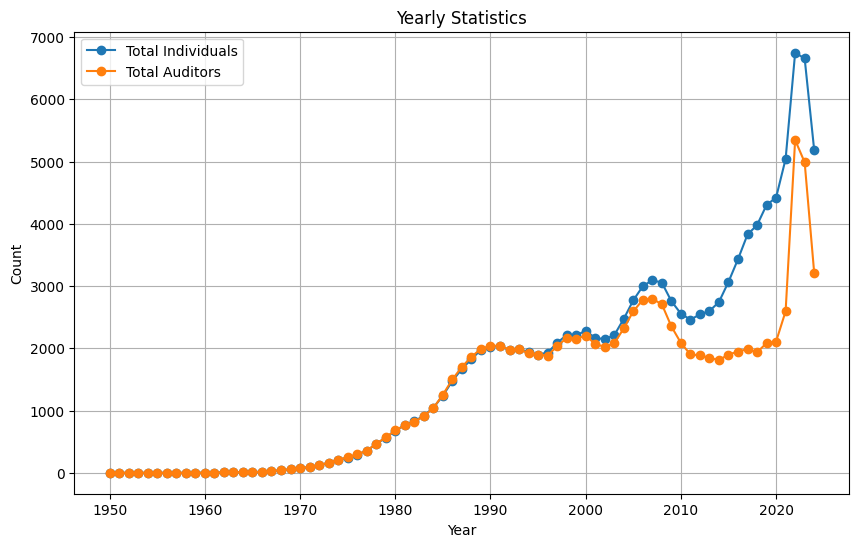

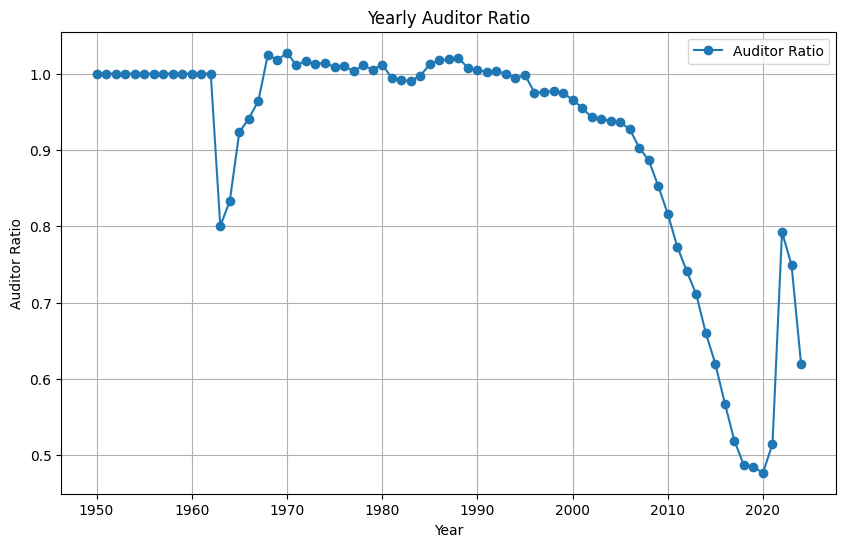

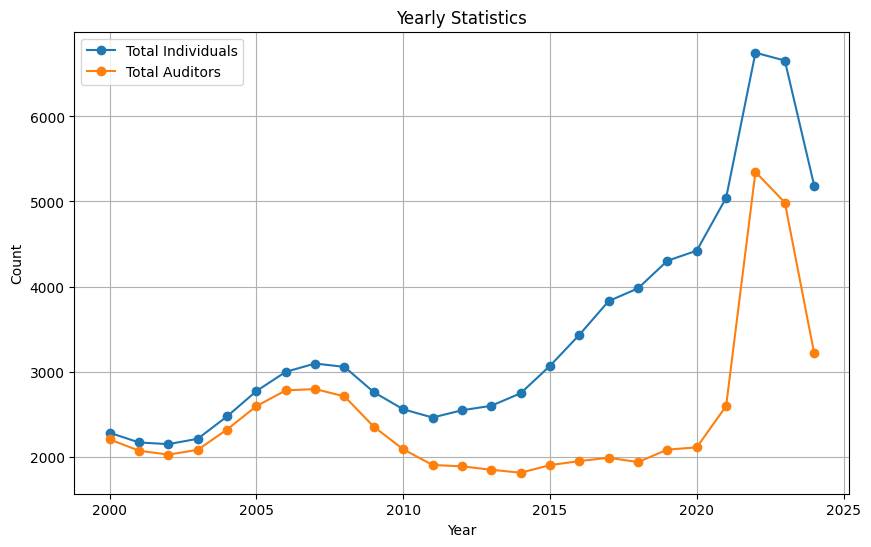

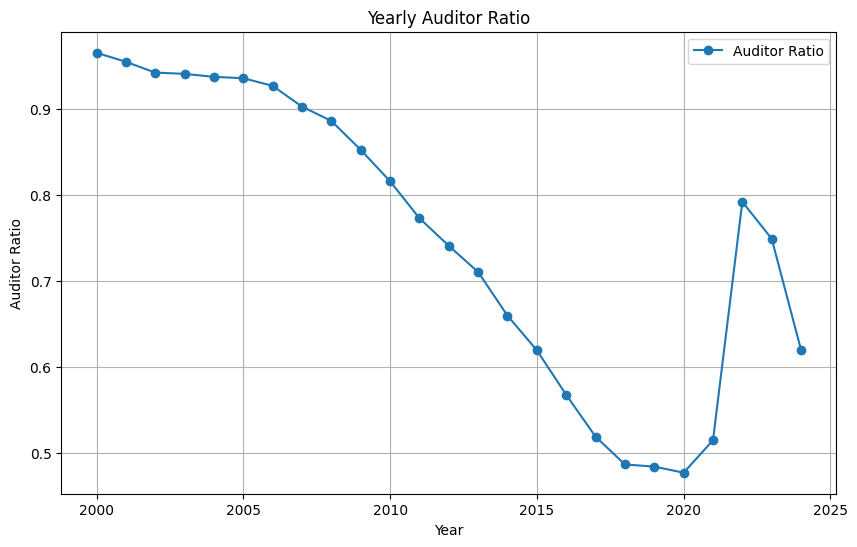

In [161]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 已经加载，并包含 "user_id", "year", "role_k1500" 三个关键列
# 这里确保 "year" 列为整数类型
df_ever_auditor['year'] = df_ever_auditor['year'].astype(int)

############################################
# (1) 计算样本中个体的人数（独特的 user_id 数量）
total_individuals = df_ever_auditor['user_id'].nunique()
print("Total unique individuals in sample:", total_individuals)

############################################
# (2) 计算中途成为 auditor 的人数
# 定义“中途成为 auditor”指该个体首次出现时职位不是 auditor，
# 但后续某一年出现 auditor 记录。

# 首先按年份排序（同一用户内的记录按时间排序）
df_sorted = df_ever_auditor.sort_values('year')

# 提取每个 user_id 的第一条记录（即该用户首次出现时的职位）
first_record = df_sorted.groupby('user_id').first().reset_index()
# 提取每个 user_id 是否曾经有 auditor 记录
ever_auditor = df_ever_auditor.groupby('user_id')['role_k1500'].apply(lambda x: (x == 'auditor').any()).reset_index()
ever_auditor.rename(columns={'role_k1500': 'ever_auditor'}, inplace=True)

# 合并用户的首次记录与是否曾经担任 auditor 的信息
user_info = pd.merge(first_record[['user_id', 'role_k1500']], ever_auditor, on='user_id')

# 选出那些首年职位不是 auditor，但后来曾经担任过 auditor 的用户
became_auditor_midstream = user_info[(user_info['role_k1500'] != 'auditor') & (user_info['ever_auditor'])]
became_auditor_midstream_count = became_auditor_midstream['user_id'].nunique()
print("Number of individuals who became auditor midstream:", became_auditor_midstream_count)

############################################
# (3) 计算中途离开 auditor 职位的个体人数
# 定义“中途离开”指个体曾经担任过 auditor，但其最后一条记录的职位不再是 auditor。
# 这种方法假设：如果个体最后状态不是 auditor，则可视为中途（或最终）离开 auditor 职位。

# 获取每个 user_id 的最后一条记录
last_record = df_sorted.groupby('user_id').last().reset_index()

# 合并是否曾经担任 auditor 信息
user_info_last = pd.merge(ever_auditor, last_record[['user_id', 'role_k1500']], on='user_id')
user_info_last.rename(columns={'role_k1500': 'last_role'}, inplace=True)

# 筛选那些曾经担任过 auditor 但最后记录不为 auditor 的用户
left_auditor = user_info_last[(user_info_last['ever_auditor']) & (user_info_last['last_role'] != 'auditor')]
left_auditor_count = left_auditor['user_id'].nunique()
print("Number of individuals who left auditor midstream:", left_auditor_count)

############################################
# (4) 针对样本中的每一年，统计：
#     - 独特个体总人数（unique user_id 数量）
#     - auditor 人数（role_k1500=='auditor' 的记录数）
#     - auditor/总人数的比例
yearly_stats = df_ever_auditor.groupby('year').agg(
    total_individuals=('user_id', 'nunique'),
    total_auditors=('role_k1500', lambda x: (x == 'auditor').sum())
).reset_index()

# 计算 auditor 占比
yearly_stats['auditor_ratio'] = yearly_stats['total_auditors'] / yearly_stats['total_individuals']

print(yearly_stats)

# 绘制时间序列图
plt.figure(figsize=(10, 6))
plt.plot(yearly_stats['year'], yearly_stats['total_individuals'], label='Total Individuals', marker='o')
plt.plot(yearly_stats['year'], yearly_stats['total_auditors'], label='Total Auditors', marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Statistics')
plt.legend()
plt.grid(True)
plt.show()

# Plot auditor ratio in a separate figure
plt.figure(figsize=(10, 6))
plt.plot(yearly_stats['year'], yearly_stats['auditor_ratio'], marker='o', linestyle='-', color='tab:blue', label='Auditor Ratio')
plt.xlabel('Year')
plt.ylabel('Auditor Ratio')
plt.title('Yearly Auditor Ratio')
plt.legend()
plt.grid(True)
plt.show()

filtered_stats = yearly_stats[yearly_stats['year'] >= 2000]

plt.figure(figsize=(10, 6))
plt.plot(filtered_stats['year'], filtered_stats['total_individuals'], label='Total Individuals', marker='o')
plt.plot(filtered_stats['year'], filtered_stats['total_auditors'], label='Total Auditors', marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Statistics')
plt.legend()
plt.grid(True)
plt.show()

# Plot auditor ratio in a separate figure
plt.figure(figsize=(10, 6))
plt.plot(filtered_stats['year'], filtered_stats['auditor_ratio'], marker='o', linestyle='-', color='tab:blue', label='Auditor Ratio')
plt.xlabel('Year')
plt.ylabel('Auditor Ratio')
plt.title('Yearly Auditor Ratio')
plt.legend()
plt.grid(True)
plt.show()


